In [ ]:
from google.colab import drive

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import itertools

from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense 
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model
from keras.layers import Dropout

Using TensorFlow backend.


In [ ]:
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')

In [ ]:
cd '/content/drive/My Drive/DCU'

/content/drive/My Drive/DCU


In [ ]:
df = pd.read_csv('OPEN_MERGE_200611.csv')

In [ ]:
df_open = df[['FN', 'MA', 'MS', 'DT', 'DP', 'T']]

#오류 데이터 삭제 (모터 전류값이 0) --> Data_20200529_121245.csv
del_idx = df_open[df_open['FN']== 'Data_20200529_121245.csv'].index
df_open = df_open.drop(del_idx)

In [ ]:
df_open.isnull().sum() #check null

FN    0
MA    0
MS    0
DT    0
DP    0
T     0
dtype: int64

In [ ]:
def data_trasform(df_source):

  time_list = []
  st = 0.55    #시간 시간
  inter = 0.05 #interval time

  for v in range(39):
    if v > 0:
      st = round(st + inter, 3)
    time_list.append(st)

  df_default = pd.DataFrame(time_list, columns=['T']) #0.55 ~ 2.45초까지 기준 구간 생성

  df_rtn = pd.merge(df_default, df_source, on=['T'], how='left')
  df_rtn.fillna(0.0, inplace=True) 

  return df_rtn[['MA']].T

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      cm = cm * 100
      print("\nNormalized confusion matrix")
  else:
      print('\nConfusion matrix, without normalization')
  print(cm)
  print ()

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.0f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [ ]:
def mean_by_door_postion(target):  
  dp1 = target[target.DP <= 100]['MA'].mean()
  dp2 = target[(target.DP > 100) & (target.DP <= 200)]['MA'].mean()
  dp3 = target[(target.DP > 200) & (target.DP <= 300)]['MA'].mean()
  dp4 = target[(target.DP > 300) & (target.DP <= 400)]['MA'].mean()
  dp5 = target[(target.DP > 400) & (target.DP <= 500)]['MA'].mean()
  dp6 = target[(target.DP > 500) & (target.DP <= 600)]['MA'].mean()
  dp7 = target[target.DP > 600]['MA'].mean()    

  '''
  dp1 = target[target.DP <= 100]['MA'].max()
  dp2 = target[(target.DP > 100) & (target.DP <= 200)]['MA'].max()
  dp3 = target[(target.DP > 200) & (target.DP <= 300)]['MA'].max()
  dp4 = target[(target.DP > 300) & (target.DP <= 400)]['MA'].max()
  dp5 = target[(target.DP > 400) & (target.DP <= 500)]['MA'].max()
  dp6 = target[(target.DP > 500) & (target.DP <= 600)]['MA'].max()
  dp7 = target[target.DP > 600]['MA'].max()      
  '''
  return pd.DataFrame({'dp1':dp1, 'dp2':dp2, 'dp3':dp3, 'dp4':dp4, 'dp5':dp5, 'dp6':dp6, 'dp7':dp7}, index=[0])
  #return pd.DataFrame({'fn':target.iloc[0]['FN'], 'dp1':dp1, 'dp2':dp2, 'dp3':dp3, 'dp4':dp4, 'dp5':dp5, 'dp6':dp6, 'dp7':dp7}, index=[0])

#시간 기준으로 입력 데이터 생성

In [ ]:
x_data = pd.DataFrame()
y_data = pd.DataFrame()

file_list = df_open['FN'].unique() #파일리스트 

for fn in file_list:    
  df_file = df_open[df_open['FN'] == fn]
  
  df_temp = df_file[(df_file['T'] > 0.5) & (df_file['T'] < 2.5)][['T','MA']]      
  
  x_data = x_data.append(data_trasform(df_temp))
  y_data = y_data.append(pd.DataFrame([df_file.iloc[0]['DT']])) 

#도어 위치 기준으로 데이터 생성

In [ ]:
x_data = pd.DataFrame()
y_data = pd.DataFrame()

file_list = df_open['FN'].unique() #파일리스트 

for fn in file_list:    
  
  df_file = df_open[df_open['FN'] == fn]  
  df_file = df_file.sort_values(by=['DP'])

  x_data = x_data.append(mean_by_door_postion(df_file))
  x_data = x_data.fillna(0)
  y_data = y_data.append(pd.DataFrame([df_file.iloc[0]['DT']])) 


In [ ]:
x_data.shape, y_data.shape
#x_data[x_data.fn == 'Data_20200529_104813.csv']  
#df_open[df_open['DT'] == 4]  

x_data.isnull().sum()

dp1    0
dp2    0
dp3    0
dp4    0
dp5    0
dp6    0
dp7    0
dtype: int64

In [ ]:
scaler = MinMaxScaler()
x_data_scaled = scaler.fit_transform(x_data)
x_train, x_test, y_train, y_test = train_test_split(x_data_scaled, y_data, test_size=0.3, shuffle=True)

In [ ]:
x_train_scaled = x_train.reshape(x_train.shape[0],x_train.shape[1],1 ) 
x_test_scaled = x_test.reshape(x_test.shape[0],x_train.shape[1],1 )

y_train = to_categorical(y_train, 6)
y_test_org = y_test
y_test = to_categorical(y_test, 6)

In [ ]:
batch_size = 10
hidden_dim = 100

In [ ]:
model = Sequential()
model.add(LSTM(hidden_dim, activation='relu', input_shape=(x_train_scaled.shape[1],x_train_scaled.shape[2]))) #activation='relu' / 'tanh'
model.add(Dropout(0.2)) #option
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 606       
Total params: 41,406
Trainable params: 41,406
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)
history = model.fit(x_train_scaled, y_train, epochs=1000, batch_size=batch_size, verbose=1, shuffle=True, callbacks=[early_stop], validation_data=(x_test_scaled, y_test))

Train on 699 samples, validate on 300 samples
Epoch 1/1000
699/699 [==============================] - 1s 1ms/step - loss: 1.5163 - accuracy: 0.6409 - val_loss: 1.0706 - val_accuracy: 0.6767
Epoch 2/1000
699/699 [==============================] - 0s 625us/step - loss: 0.8638 - accuracy: 0.7582 - val_loss: 0.8134 - val_accuracy: 0.7600
Epoch 3/1000
699/699 [==============================] - 0s 640us/step - loss: 0.7898 - accuracy: 0.7725 - val_loss: 0.7672 - val_accuracy: 0.7700
Epoch 4/1000
699/699 [==============================] - 0s 642us/step - loss: 0.7738 - accuracy: 0.7768 - val_loss: 0.7690 - val_accuracy: 0.7700
Epoch 5/1000
699/699 [==============================] - 0s 702us/step - loss: 0.7519 - accuracy: 0.7840 - val_loss: 0.8225 - val_accuracy: 0.7667
Epoch 6/1000
699/699 [==============================] - 0s 666us/step - loss: 0.7350 - accuracy: 0.7811 - val_loss: 0.7554 - val_accuracy: 0.7733
Epoch 7/1000
699/699 [==============================] - 0s 666us/step - loss: 0.

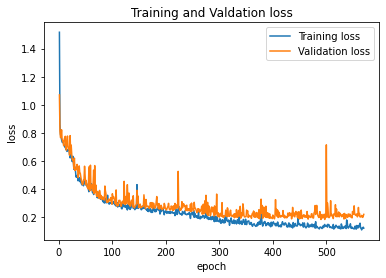

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Valdation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show() 

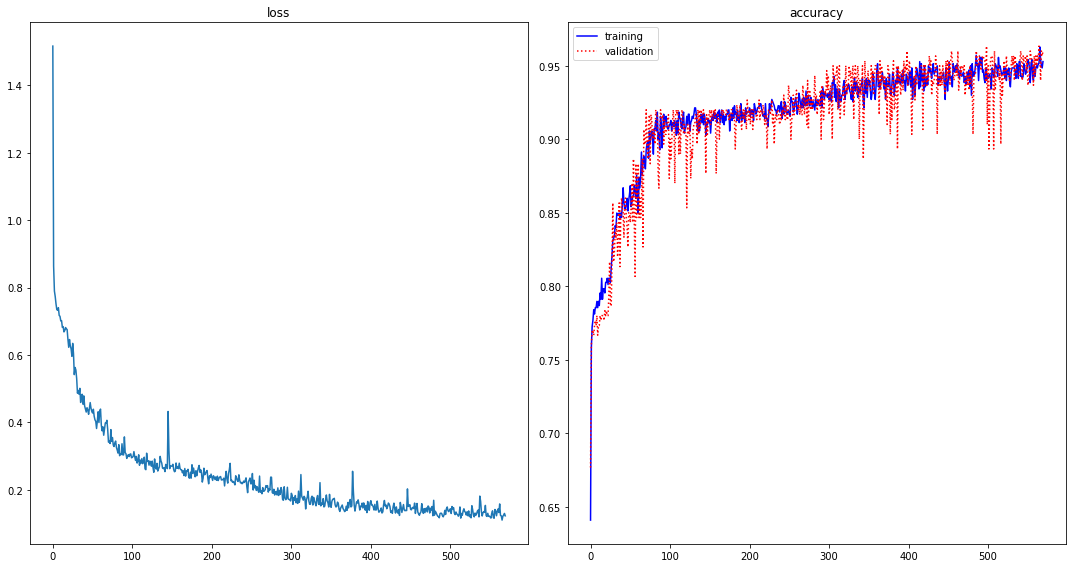

In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title("loss")
plt.subplot(1, 2, 2)
plt.title("accuracy")
plt.plot(history.history['accuracy'], 'b-', label="training")
plt.plot(history.history['val_accuracy'], 'r:', label="validation")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
score = model.evaluate(x_test_scaled, y_test, batch_size=batch_size)

300/300 [==============================] - 0s 155us/step


In [ ]:
score

[0.22107179538725177, 0.9599999785423279]

In [ ]:
#y_hat = model.predict(x_test_scaled)
y_hat = model.predict_classes(x_test_scaled)
y_hat

array([0, 0, 0, 0, 5, 0, 1, 3, 1, 0, 0, 0, 0, 5, 0, 3, 0, 0, 1, 0, 5, 0,
       0, 0, 0, 1, 0, 5, 1, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       3, 0, 0, 0, 1, 0, 0, 0, 1, 0, 5, 3, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 4, 1, 3, 0, 3, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 5, 0, 0, 2, 0,
       0, 0, 0, 4, 0, 0, 0, 1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 3, 0, 3, 3, 0, 0, 3, 0,
       3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 4, 1, 2, 0, 0, 0, 0, 0, 3, 0, 0,
       3, 0, 1, 0, 3, 0, 5, 0, 0, 0, 4, 0, 3, 3, 2, 1, 3, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 2, 0, 0, 4, 2, 1, 0, 5, 0, 0, 0, 1, 0, 0, 1, 2, 3, 0,
       3, 0, 0, 1, 3, 3, 0, 0, 2, 3, 4, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 3,
       4, 1, 0, 0, 1, 0, 0, 3, 0, 2, 0, 0, 0, 3, 4, 5, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 4, 0, 1, 0, 0, 0, 1, 4, 0,
       4, 0, 5, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0])

In [ ]:
ds = pd.DataFrame()
ds['y_test'] = np.squeeze(y_test_org.values, axis=1)
ds['y_hat'] = y_hat


Confusion matrix, without normalization
[[190   1   1   0   0   0]
 [  1  34   2   0   0   0]
 [  5   0   8   0   0   0]
 [  0   0   0  32   0   0]
 [  1   1   0   0  13   0]
 [  0   0   0   0   0  11]]



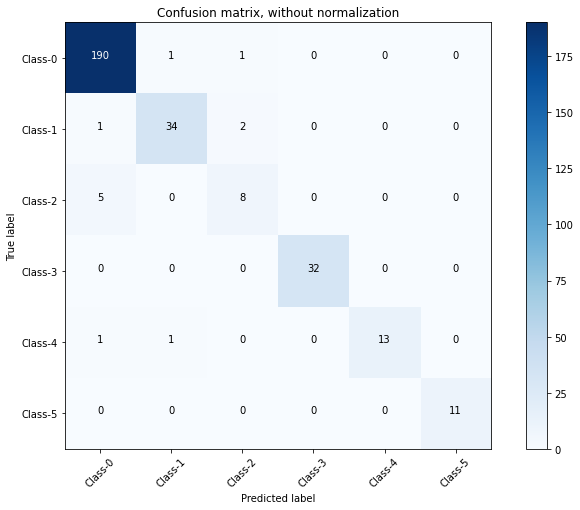


Normalized confusion matrix
[[ 98.95833333   0.52083333   0.52083333   0.           0.
    0.        ]
 [  2.7027027   91.89189189   5.40540541   0.           0.
    0.        ]
 [ 38.46153846   0.          61.53846154   0.           0.
    0.        ]
 [  0.           0.           0.         100.           0.
    0.        ]
 [  6.66666667   6.66666667   0.           0.          86.66666667
    0.        ]
 [  0.           0.           0.           0.           0.
  100.        ]]



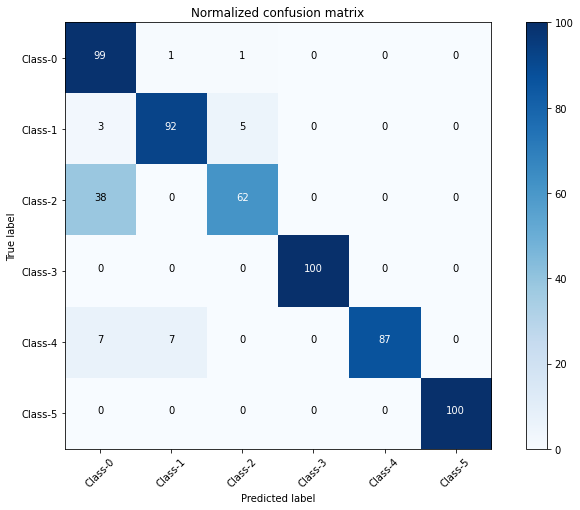

In [ ]:
cm = confusion_matrix(y_test_org, y_hat, labels=[0,1,2,3,4,5])


class_names = ['Class-0','Class-1','Class-2','Class-3','Class-4','Class-5']
plt.figure(figsize=(10,7))
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,7))
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
targets = ['Class-0', 'Class-1', 'Class-2', 'Class-3', 'Class-4', 'Class-5']
print(classification_report(y_test_org, y_hat, target_names=targets))

              precision    recall  f1-score   support

     Class-0       0.96      0.99      0.98       192
     Class-1       0.94      0.92      0.93        37
     Class-2       0.73      0.62      0.67        13
     Class-3       1.00      1.00      1.00        32
     Class-4       1.00      0.87      0.93        15
     Class-5       1.00      1.00      1.00        11

    accuracy                           0.96       300
   macro avg       0.94      0.90      0.92       300
weighted avg       0.96      0.96      0.96       300



In [ ]:
model.save('door_dp_mean_lstm.hdf5')
#del model

In [ ]:
#model = load_model('door_lstm.hdf5')
#y_hat = model.predict(x_test_scaled)